In [1]:
import pandas as pd
import torch
import os

# 수정된 로컬 모듈들을 임포트합니다.
from data_process import get_market_data
from env import MultiAssetPortfolioEnv
from agent import Agent
from evaluation import evaluate_agent
from utils import calculate_initial_weights # utils.py에 추가할 초기 가중치 계산 함수

try:
    torch.multiprocessing.set_start_method('fork', force=True)
except RuntimeError:
    pass

In [2]:
# =================================================================================
# 1. 설정 (Configuration)
# =================================================================================

# --- 데이터 관련 파라미터 ---
TICKERS = [
    # 기술주
    "AAPL", "MSFT", "NVDA", "SMCI",
    # 통신 및 플랫폼
    "GOOGL", "META",
    # 소비재
    "AMZN", "TSLA", "COST", "KO",
    # 금융
    "JPM", "V",
    # 헬스케어
    "JNJ", "LLY",
    # 산업 및 에너지
    "CAT", "XOM",
    # ETF (시장, 섹터, 원자재, 채권)
    "SPY", "QQQ", "SOXX", "XLE", "GLD", "TLT", "SHY", "BIL",
    # 리츠
    "O"
]

START_DATE = "2015-01-01"
TRAIN_END_DATE = "2020-12-31"
VALIDATION_END_DATE = "2022-12-31"
TEST_END_DATE = "2024-12-31"

# --- 환경 관련 파라미터 ---
INITIAL_PORTFOLIO_VALUE = 1000000  # 초기 포트폴리오 가치 (백만 달러)
TRANSACTION_COST_PCT = 0.001       # 거래 비용 (0.1%)
RISK_AVERSION_COEFF = 0.01         # 위험 회피 계수 (보상 함수에 사용)

# --- 에이전트 및 훈련 관련 파라미터 ---
RANDOM_SEED = 42
N_EPISODES = 50  # 훈련 에피소드 수

# --- 추가된 부분: 모델 저장 경로 ---
MODEL_SAVE_PATH = "./saved_models"
if not os.path.exists(MODEL_SAVE_PATH):
    os.makedirs(MODEL_SAVE_PATH)

In [3]:
# =================================================================================
# 2. 데이터 준비 (Data Preparation)
# =================================================================================
print(f"\n[1/5] 📈 데이터 로딩 및 전처리 중... (기간: {START_DATE} ~ {TEST_END_DATE})")
full_data_df = get_market_data(
    tickers=TICKERS,
    start_date=START_DATE,
    end_date=TEST_END_DATE
)

# 훈련 데이터와 테스트 데이터 분리 (Lookahead Bias 방지)
train_df = full_data_df.loc[:TRAIN_END_DATE]
validation_df = full_data_df.loc[TRAIN_END_DATE:VALIDATION_END_DATE].iloc[1:]
test_df = full_data_df.loc[VALIDATION_END_DATE:].iloc[1:]
print(f"✅ 데이터 준비 완료: 훈련 {len(train_df)}일, 검증 {len(validation_df)}일, 테스트 {len(test_df)}일")


[1/5] 📈 데이터 로딩 및 전처리 중... (기간: 2015-01-01 ~ 2024-12-31)


[*********************100%***********************]  25 of 25 completed
[*********************100%***********************]  25 of 25 completed
/workspaces/Deep-RL-for-Portfolio-Optimization/data_process.py:33: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  adj_close_data.fillna(method='ffill', inplace=True)
/workspaces/Deep-RL-for-Portfolio-Optimization/data_process.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  adj_close_data.fillna(method='ffill', inplace=True)
/workspaces/Deep-RL-for-Portfolio-Optimization/data_process.py:34: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  adj_close_data.fillna(method='bfill', inplac

✅ 데이터 준비 완료: 훈련 1452일, 검증 503일, 테스트 500일


In [4]:
# =================================================================================
# 3. 환경 및 에이전트 생성 (Instantiation)
# =================================================================================
print("\n[2/5] 🛠️  환경 및 에이전트 생성 중...")

initial_weights = calculate_initial_weights(assets=TICKERS, method='equal')

# 훈련 환경 생성
train_env = MultiAssetPortfolioEnv(
    df=train_df, assets=TICKERS, initial_weights=initial_weights,
    initial_portfolio_value=INITIAL_PORTFOLIO_VALUE,
    transaction_cost_pct=TRANSACTION_COST_PCT, risk_aversion_coeff=RISK_AVERSION_COEFF
)

# 검증 환경 생성
validation_env = MultiAssetPortfolioEnv(
    df=validation_df, assets=TICKERS, initial_weights=initial_weights,
    initial_portfolio_value=INITIAL_PORTFOLIO_VALUE,
    transaction_cost_pct=TRANSACTION_COST_PCT, risk_aversion_coeff=RISK_AVERSION_COEFF
)

# 테스트 환경 생성
test_env = MultiAssetPortfolioEnv(
    df=test_df, assets=TICKERS, initial_weights=initial_weights,
    initial_portfolio_value=INITIAL_PORTFOLIO_VALUE,
    transaction_cost_pct=TRANSACTION_COST_PCT, risk_aversion_coeff=RISK_AVERSION_COEFF
)

# 환경으로부터 state 및 action 크기 확보 (훈련 환경 기준)
state_size = train_env.observation_space.shape[0]
action_size = train_env.action_space.shape[0]

# 에이전트 생성
agent = Agent(state_size=state_size, action_size=action_size, random_seed=RANDOM_SEED)
print(f"✅ 에이전트 생성 완료: State Size={state_size}, Action Size={action_size}")


[2/5] 🛠️  환경 및 에이전트 생성 중...
✅ 에이전트 생성 완료: State Size=4826, Action Size=26


In [5]:
# =================================================================================
# 4. 모델 훈련 (Training)
# =================================================================================
print(f"\n[3/5] 🧠 모델 훈련 시작... (총 {N_EPISODES} 에피소드, 5 에피소드마다 검증)")

# agent.py의 train 메소드가 tqdm을 내장하고 있으므로 여기서 호출만 하면 됩니다.
agent.train(
    train_env=train_env,
    validation_env=validation_env,
    n_episodes=N_EPISODES,
    model_path=MODEL_SAVE_PATH
)

print("\n✅ 모델 훈련 완료.")


[3/5] 🧠 모델 훈련 시작... (총 50 에피소드, 5 에피소드마다 검증)


Training Progress (TD3):  10%|█         | 5/50 [07:46<1:07:25, 89.90s/it, Avg Train Score=1.27, Exploration=0.185] 


Episode 5	Avg Train Score: 1.27	Validation Sharpe Ratio: -0.4231
🎉 New best model found! Saving model to ./saved_models


Training Progress (TD3):  20%|██        | 10/50 [15:05<58:34, 87.87s/it, Avg Train Score=1.70, Exploration=0.170] 


Episode 10	Avg Train Score: 1.70	Validation Sharpe Ratio: 0.4285
🎉 New best model found! Saving model to ./saved_models


Training Progress (TD3):  30%|███       | 15/50 [22:18<50:17, 86.20s/it, Avg Train Score=2.39, Exploration=0.155]


Episode 15	Avg Train Score: 2.39	Validation Sharpe Ratio: 0.0215


Training Progress (TD3):  40%|████      | 20/50 [29:29<43:00, 86.03s/it, Avg Train Score=2.46, Exploration=0.140]


Episode 20	Avg Train Score: 2.46	Validation Sharpe Ratio: -0.1226


Training Progress (TD3):  40%|████      | 20/50 [29:50<44:45, 89.50s/it, Avg Train Score=2.46, Exploration=0.140]


KeyboardInterrupt: 


[4/5] 📊 최적 모델 로드 및 최종 평가 시작 (Out-of-Sample Backtest)...
✅ 최적 모델 가중치를 성공적으로 로드했습니다.
--- Running Backtest for TD3 Agent ---

--- Running Backtest for Equal Weight Benchmark ---

               PERFORMANCE SUMMARY
             CAGR Annualized Volatility Sharpe Ratio Max Drawdown (MDD)
TD3 Agent  -1.86%                15.75%        -0.12            -15.95%
Benchmark  28.97%                13.30%         2.18             -9.50%



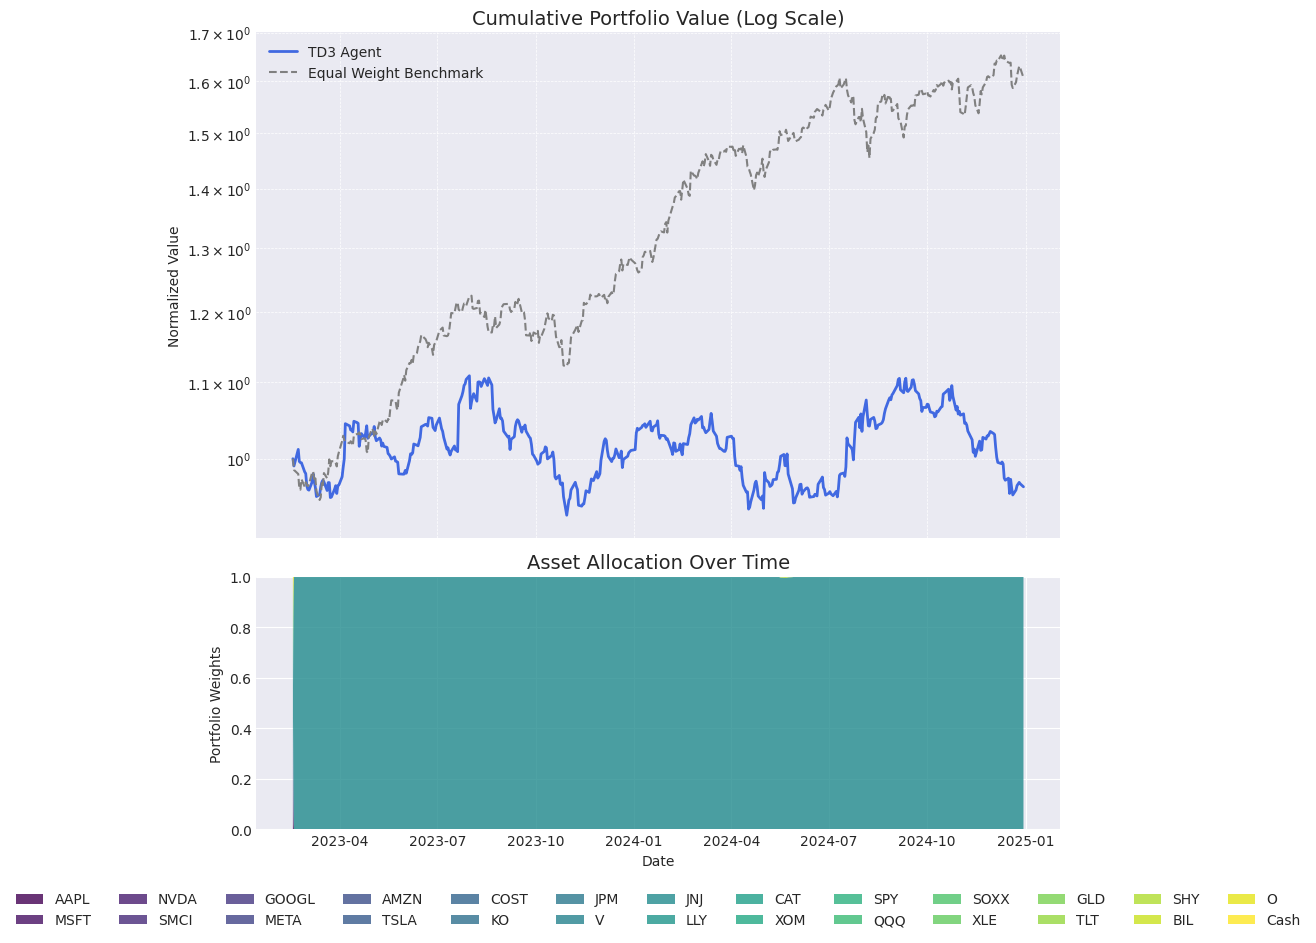


[5/5] ✅ 평가 및 시각화 완료.


In [6]:
# =================================================================================
# 5. 모델 평가 (Evaluation)
# =================================================================================
print("\n[4/5] 📊 최적 모델 로드 및 최종 평가 시작 (Out-of-Sample Backtest)...")

# TD3 구조에 맞게 최적 모델 가중치 로드
try:
    actor_weights = torch.load(os.path.join(MODEL_SAVE_PATH, 'best_actor.pth'))
    agent.actor_local.load_state_dict(actor_weights)

    # 저장된 critic 가중치를 두 개의 critic 모두에 로드
    critic_weights = torch.load(os.path.join(MODEL_SAVE_PATH, 'best_critic.pth'))
    agent.critic_1_local.load_state_dict(critic_weights)
    agent.critic_2_local.load_state_dict(critic_weights)
    
    print("✅ 최적 모델 가중치를 성공적으로 로드했습니다.")

except FileNotFoundError:
    print("⚠️ 저장된 최적 모델을 찾을 수 없습니다. 마지막 에피소드의 모델로 평가합니다.")

# evaluation.py의 평가 함수 호출
evaluate_agent(env=test_env, agent=agent)
print("\n[5/5] ✅ 평가 및 시각화 완료.")
print("="*80)